In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from tqdm.notebook import trange, tqdm
import scipy as sp
from astropy.io import ascii
import emcee
import corner
plt.style.use('tableau-colorblind10')

### Load previously generated sensitivity grids

In [2]:
projSepGrid = np.load('data/projSepGrid.npy')
qGrid = np.load('data/qGrid.npy')

totSensMalmQATMO0p9 = np.load('data/totSensMalmQATMO0p9.npy')
totSensMalmQATMO1p2 = np.load('data/totSensMalmQATMO1p2.npy')
totSensMalmQATMO1p5 = np.load('data/totSensMalmQATMO1p5.npy')
totSensMalmQATMO1p9 = np.load('data/totSensMalmQATMO1p9.npy')
totSensMalmQATMO2p4 = np.load('data/totSensMalmQATMO2p4.npy')
totSensMalmQATMO3p1 = np.load('data/totSensMalmQATMO3p1.npy')


print(np.shape(projSepGrid),np.shape(qGrid),np.shape(totSensMalmQATMO1p5))

psgg,qgg = np.meshgrid(projSepGrid,qGrid)#,indexing='ij')
print(np.shape(psgg),np.shape(qgg))
lg10psgg = np.log10(psgg)
maxpsgrid = np.max(projSepGrid)
maxpsgriddelta = projSepGrid[-1]-projSepGrid[-2]

(1000,) (1001,) (1001, 1000)
(1001, 1000) (1001, 1000)


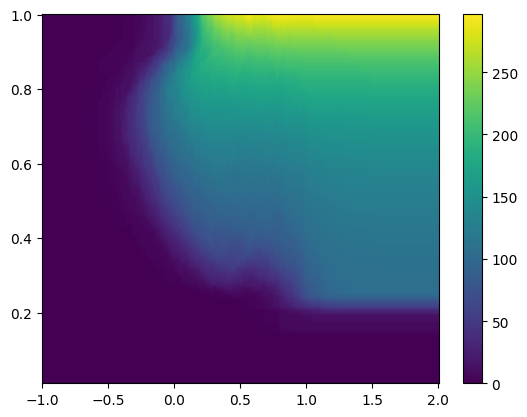

In [3]:
cax = plt.pcolormesh(np.log10(projSepGrid),qGrid,totSensMalmQATMO0p9)
#plt.xscale('log')
plt.colorbar(cax)

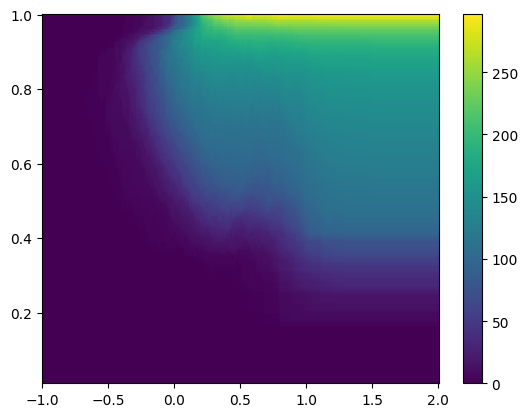

In [4]:
cax = plt.pcolormesh(np.log10(projSepGrid),qGrid,totSensMalmQATMO3p1)
#plt.xscale('log')
plt.colorbar(cax)

### Load table of detections

In [5]:
detTable = ascii.read('data/detectionsTabMass.csv')
print(detTable.colnames)
#get rid of marginal detection
detTable['c0_weightedMean'][np.where(detTable['source'] == '2M 2028+0052')] = np.nan
detTable['projSep'][np.where(detTable['source'] == '2M 2028+0052')] = np.nan

['target', 'source', 'sep_weightedMean', 'pa_weightedMean', 'c0_weightedMean', 'c1_weightedMean', 'ssep_weightedMean', 'spa_weightedMean', 'sc0_weightedMean', 'sc1_weightedMean', 'ssep_medianErr', 'spa_medianErr', 'sc0_medianErr', 'sc1_medianErr', 'sysstd_sep', 'sysstd_pa', 'sysstd_c0', 'sysstd_c1', 'sysrms_sep', 'sysrms_pa', 'sysrms_c0', 'sysrms_c1', 'ncal', 'cals', 'pa_weightedMean_degrees', 'spa_weightedMean_degrees', 'spa_medianErr_degrees', 'sysstd_pa_degrees', 'sysrms_pa_degrees', 'dist', 'sdist', 'sep', 'ssep', 'projSep', 'sprojSep', '2MASSphotFlag110', '2MASSphotFlag170', 'm110', 'm170', 'sm110', 'sm170', 'M110', 'M170', 'sM110', 'sM170', 'logLA', 'logLB', 'slogLA', 'slogLB', 'qATMO0p9', 'maATMO0p9', 'mbATMO0p9', 'sqATMO0p9', 'smaATMO0p9', 'smbATMO0p9', 'qATMO1p2', 'maATMO1p2', 'mbATMO1p2', 'sqATMO1p2', 'smaATMO1p2', 'smbATMO1p2', 'qATMO1p5', 'maATMO1p5', 'mbATMO1p5', 'sqATMO1p5', 'smaATMO1p5', 'smbATMO1p5', 'qATMO1p9', 'maATMO1p9', 'mbATMO1p9', 'sqATMO1p9', 'smaATMO1p9', 'smbA

In [6]:
detTable.show_in_notebook()

idx,target,source,sep_weightedMean,pa_weightedMean,c0_weightedMean,c1_weightedMean,ssep_weightedMean,spa_weightedMean,sc0_weightedMean,sc1_weightedMean,ssep_medianErr,spa_medianErr,sc0_medianErr,sc1_medianErr,sysstd_sep,sysstd_pa,sysstd_c0,sysstd_c1,sysrms_sep,sysrms_pa,sysrms_c0,sysrms_c1,ncal,cals,pa_weightedMean_degrees,spa_weightedMean_degrees,spa_medianErr_degrees,sysstd_pa_degrees,sysrms_pa_degrees,dist,sdist,sep,ssep,projSep,sprojSep,2MASSphotFlag110,2MASSphotFlag170,m110,m170,sm110,sm170,M110,M170,sM110,sM170,logLA,logLB,slogLA,slogLB,qATMO0p9,maATMO0p9,mbATMO0p9,sqATMO0p9,smaATMO0p9,smbATMO0p9,qATMO1p2,maATMO1p2,mbATMO1p2,sqATMO1p2,smaATMO1p2,smbATMO1p2,qATMO1p5,maATMO1p5,mbATMO1p5,sqATMO1p5,smaATMO1p5,smbATMO1p5,qATMO1p9,maATMO1p9,mbATMO1p9,sqATMO1p9,smaATMO1p9,smbATMO1p9,qATMO2p4,maATMO2p4,mbATMO2p4,sqATMO2p4,smaATMO2p4,smbATMO2p4,qATMO3p1,maATMO3p1,mbATMO3p1,sqATMO3p1,smaATMO3p1,smbATMO3p1
0,data/10143/U20004/,2M 0004-4044,0.08319088112,0.7738399121,1.125983905,nan,0.000224630421,0.004544961219,0.008034902292,nan,0.00049,0.0099,0.018,nan,0.0001180847154,0.007259090852,0.003709447398,nan,0.0001190186863,0.007327634287,0.003715736393,nan,5,"2M 1539-0520, 2M 2148+4003, 2M 0727+1710, 2M 0355+1133, 2M 0243-2453",44.33776098,0.2604070959,0.5672282172,0.4159152689,0.4198425184,12.129407,0.03487500000000043,0.08319088112,0.00049,1.0090560557930959,0.006613739696618808,0.0,0.0,13.79627412,12.09627412,0.05,0.05,13.377076275157274,11.677076275157274,0.05038830662248215,0.05038830662248215,-4.164318236344465,-4.20826018834633,0.017564757535337674,0.017680056055003238,0.9703519851293873,61.22758939422344,59.412312913371736,0.01648843874644669,0.7052712625344382,0.7421828497036267,0.9767341423250858,66.09228892170898,64.5545951342472,0.01304376948493922,0.613970488237856,0.6193386750607386,0.9818842231068292,70.07737264780727,68.80786659966,0.010122898946204046,0.4944891797569054,0.5171926662113419,0.9865761452472611,72.85786049250365,71.87982715565697,0.007538143788212292,0.38352766953367423,0.398075487797438,0.989983589567038,74.66547317062124,73.91759314617299,0.005652816627871942,0.29012351229798367,0.30927233310076524,0.9922049062049951,75.82600374373126,75.23493293244849,0.004433052934884632,0.23317873018510984,0.24384957049782743
1,data/10143/U13016/,2M 0025+4759,0.3345483896,4.063003412,1.352909943,1.250589047,0.0003984896868,0.001016890005,0.01474991177,0.01019159261,0.00088,0.0022,0.033,0.023,4.96e-05,8.94e-05,0.002993325909,0.001019803903,4.97e-05,8.95e-05,0.002995344288,0.001019862724,5,"2M 2139+0220, 2M 0243-2453, 2M 2351-2537, 2M 0228+1639, 2M 0825+2115",232.7929477,0.05826350551,0.1260507149,0.005124690313,0.005128418739,53.99568034557235,0.40817468943737206,0.3345483896,0.00088,18.0641679049676,0.1445850427520376,0.0,0.0,15.55910117,13.55103254,0.05,0.05,11.897306081729578,9.889237451729578,0.05262559095137935,0.05262559095137935,-3.532092508015108,-3.6374825051018065,0.014031834229722854,0.01422395840766295,0.9589043577231203,82.78318148544332,79.38115347257553,0.007659581297113916,0.45405666785960636,0.46096929218415605,0.9655442727034423,84.15898774408326,81.25922861281879,0.006434783097645716,0.38729607692082874,0.3917027876936392,0.9727006440368412,84.41691049741182,82.11238320843286,0.005103150366190366,0.3065325654775151,0.31093389224035056,0.9778650726711837,84.33501508263218,82.46826565250349,0.00415119234843004,0.248148967710535,0.25235209793183144,0.9810833237995967,84.25199961200403,82.65823181610725,0.003545652451848548,0.21174993981079965,0.21466460809821308,0.9838022545185098,83.94518515275416,82.58546240925328,0.003044606407729181,0.18078588016964997,0.18354250419683835
2,data/10143/U20081/,2M 0147-4954,0.1388452706,1.267824019,2.345447425,2.021867815,0.0002034058838,0.001234309144,0.01497855851,0.00757256289,0.00042,0.0025,0.03,0.016,0.0008553034549,0.003391164992,0.2198994316,0.08075989104,0.0008557858256,0.003439731716,0.2204988409,0.08163661576,5,"2M 1058-1548, 2M 1421+1827, 2M 0123-4240, 2M 0

### Make list of relevant info for all detections from the big table

In [7]:
qsATMO0p9 = []
sepsATMO0p9 = []

qsATMO1p2 = []
sepsATMO1p2 = []

qsATMO1p5 = []
sepsATMO1p5 = []

qsATMO1p9 = []
sepsATMO1p9 = []

qsATMO2p4 = []
sepsATMO2p4 = []

qsATMO3p1 = []
sepsATMO3p1 = []

detContsAvg = []
detContsMin = []
detContsJ = []

for line in detTable:
#for target in c0goodDet:
    #results = binResultsTab[np.where(np.bitwise_and(binResultsTab['target']==target, np.array(binResultsTab['detectionC0'])))]
    if not np.isnan(line['projSep']):
        
        detContsAvg += [np.nanmean([line['c0_weightedMean'],line['c1_weightedMean']])]
        detContsMin += [np.nanmin([line['c0_weightedMean'],line['c1_weightedMean']])]
        detContsJ += [line['c0_weightedMean'] if ~np.isnan(line['c0_weightedMean']) else line['c1_weightedMean']]

        qsATMO0p9 += [line['qATMO0p9']]
        sepsATMO0p9 += [line['projSep']]
        
        qsATMO1p2 += [line['qATMO1p2']]
        sepsATMO1p2 += [line['projSep']]
        
        qsATMO1p5 += [line['qATMO1p5']]
        sepsATMO1p5 += [line['projSep']]
        
        qsATMO1p9 += [line['qATMO1p9']]
        sepsATMO1p9 += [line['projSep']]
        
        qsATMO2p4 += [line['qATMO2p4']]
        sepsATMO2p4 += [line['projSep']]

        qsATMO3p1 += [line['qATMO3p1']]
        sepsATMO3p1 += [line['projSep']]
        
        
        print(line['source'])

2M 0004-4044
2M 0025+4759
2M 0147-4954
2M 0423-0414
2M 0429-3123
2M 0700+3157
2M 0915+0422
2M 0926+5847
2M 1021-0304
2M 1553+1532
2M 1707-0558
2M 2152+0937
2M 2252-1730
2M 2255-5713
2M 2351-2537


### Make detections grid used in fitting and bin down the full resolution grids

In [8]:
######## make detection grid
nps = 175
nqs = 50

minps = np.logspace(-4,3,nps,endpoint=0)
minlogps = np.log10(minps)
dlps = minlogps[1]-minlogps[0]
logps = minlogps + dlps/2.
ps = np.power(10.,logps)

maxqs = np.linspace(1.,0.,nqs,endpoint=0)[::-1]
dqs = maxqs[1]-maxqs[0]
qs = maxqs - dqs/2.

print(dlps,dqs)

lpps,qqs = np.meshgrid(logps,qs)#,indexing='ij')

print(np.shape(lpps),np.shape(qqs))

0.040000000000000036 0.020000000000000018
(50, 175) (50, 175)


In [9]:
detsATMO0p9 = np.zeros((nqs,nps))
contsATMO0p9 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO0p9,sepsATMO0p9,detContsJ):
    detsATMO0p9[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO0p9[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)

detsATMO1p2 = np.zeros((nqs,nps))
contsATMO1p2 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO1p2,sepsATMO1p2,detContsJ):
    detsATMO1p2[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO1p2[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)

detsATMO1p5 = np.zeros((nqs,nps))
contsATMO1p5 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO1p5,sepsATMO1p5,detContsJ):
    detsATMO1p5[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO1p5[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)
    
detsATMO1p9 = np.zeros((nqs,nps))
contsATMO1p9 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO1p9,sepsATMO1p9,detContsJ):
    detsATMO1p9[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO1p9[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)

detsATMO2p4 = np.zeros((nqs,nps))
contsATMO2p4 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO2p4,sepsATMO2p4,detContsJ):
    detsATMO2p4[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO2p4[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)
    
detsATMO3p1 = np.zeros((nqs,nps))
contsATMO3p1 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO3p1,sepsATMO3p1,detContsJ):
    detsATMO3p1[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO3p1[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)

In [10]:
######## Takes a long time

sensATMO0p9Malm = np.zeros((nqs,nps))
sensATMO1p2Malm = np.zeros((nqs,nps))
sensATMO1p5Malm = np.zeros((nqs,nps))
sensATMO1p9Malm = np.zeros((nqs,nps))
sensATMO2p4Malm = np.zeros((nqs,nps))
sensATMO3p1Malm = np.zeros((nqs,nps))

for i,p in enumerate(tqdm(minlogps)):
    if p>=np.log10(maxpsgrid):
        p = np.log10(maxpsgrid-maxpsgriddelta)
        print('edge case')
    for j,q in enumerate(maxqs):
        ids = np.where((p < lg10psgg)&(lg10psgg < p+dlps) & (q-dqs < qgg)&(qgg < q))
        
        senssATMO0p9Malm = totSensMalmQATMO0p9[ids]
        sensATMO0p9Malm[j,i] = np.median(senssATMO0p9Malm)
        
        senssATMO1p2Malm = totSensMalmQATMO1p2[ids]
        sensATMO1p2Malm[j,i] = np.median(senssATMO1p2Malm)
        
        senssATMO1p5Malm = totSensMalmQATMO1p5[ids]
        sensATMO1p5Malm[j,i] = np.median(senssATMO1p5Malm)
        
        senssATMO1p9Malm = totSensMalmQATMO1p9[ids]
        sensATMO1p9Malm[j,i] = np.median(senssATMO1p9Malm)
        
        senssATMO2p4Malm = totSensMalmQATMO2p4[ids]
        sensATMO2p4Malm[j,i] = np.median(senssATMO2p4Malm)
        
        senssATMO3p1Malm = totSensMalmQATMO3p1[ids]
        sensATMO3p1Malm[j,i] = np.median(senssATMO3p1Malm)

sensATMO0p9Malm[np.where(np.isnan(sensATMO0p9Malm))] = 0.
sensATMO1p2Malm[np.where(np.isnan(sensATMO1p2Malm))] = 0.
sensATMO1p5Malm[np.where(np.isnan(sensATMO1p5Malm))] = 0.
sensATMO1p9Malm[np.where(np.isnan(sensATMO1p9Malm))] = 0.
sensATMO2p4Malm[np.where(np.isnan(sensATMO2p4Malm))] = 0.
sensATMO3p1Malm[np.where(np.isnan(sensATMO3p1Malm))] = 0.

0
1


/Users/sfactor/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sfactor/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
edge case
151
edge case
152
edge case
153
edge case
154
edge case
155
edge case
156
edge case
157
edge case
158
edge case
159
edge case
160
edge case
161
edge case
162
edge case
163
edge case
164
edge case
165
edge case
166
edge case
167
edge case
168
edge case
169
edge case
170
edge case
171
edge case
172
edge case
173
edge case
174
edge case


In [11]:
print(np.shape(sensATMO1p5Malm),np.shape(totSensMalmQATMO1p5),np.shape(psgg))

(50, 175) (1001, 1000) (1001, 1000)


### Prepare for fitting
un-comment the relevant parameters

In [12]:
# dets = detsATMO0p9
# sens = sensATMO0p9Malm
# ageStr = '0p9'
# sampStr = 'Malm'

# dets = detsATMO1p2
# sens = sensATMO1p2Malm
# ageStr = '1p2'
# sampStr = 'Malm'

# dets = detsATMO1p5
# sens = sensATMO1p5Malm
# ageStr = '1p5'
# sampStr = 'Malm'

# dets = detsATMO1p9
# sens = sensATMO1p9Malm
# ageStr = '1p9'
# sampStr = 'Malm'

# dets = detsATMO2p4
# sens = sensATMO2p4Malm
# ageStr = '2p4'
# sampStr = 'Malm'

dets = detsATMO3p1
sens = sensATMO3p1Malm
ageStr = '3p1'
sampStr = 'Malm'

#dets [10,30]+=1

#dets = detsc1
#sens = sensc1

print(sum(sum(dets)))

15.0


/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_4038/2927658761.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "C0." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(logps[np.where(dets)[1]],qs[np.where(dets)[0]],'C0.',marker='.')


Text(0.5, 0, '$\\log\\rho~[\\mathrm{au}]$')

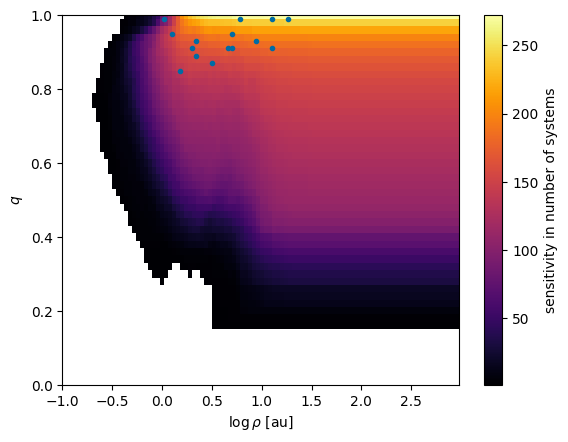

In [13]:
pltsens = np.copy(sens)
pltsens[np.where(pltsens==0)] = np.nan
cax = plt.pcolormesh(minlogps,maxqs,pltsens,cmap='inferno')
plt.colorbar(cax,label = "sensitivity in number of systems")
plt.plot(logps[np.where(dets)[1]],qs[np.where(dets)[0]],'C0.',marker='.')
# cax2=plt.scatter(np.append(logps[np.where(dets)[1]],[-2,-2]),np.append(qs[np.where(dets)[0]],[0,0]),marker='.',c=np.append(dets[np.where(dets)],[0.,1.]),cmap='Blues')
# plt.colorbar(cax2,label='malmquist weighted detections')
plt.ylim(0,1)
(x_l,x_u) = plt.gca().get_xlim()
plt.xlim(-1.,x_u)
plt.ylabel(r"$q$")
plt.xlabel(r"$\log\rho~[\mathrm{au}]$")
#plt.plot(logps[np.where(sens==0)[1]],qs[np.where(sens==0)[0]],'C1.')
# plt.savefig('figs/'+sampStr+ageStr+'GyrSens.pdf',bbox_inches = 'tight')

(75.0, 150.0)

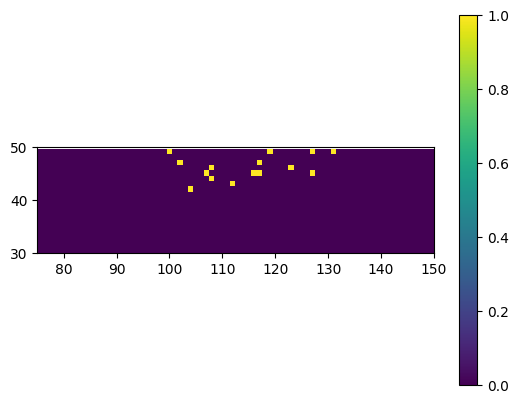

In [14]:
# cax = plt.pcolormesh(minlogps,maxqs,dets,cmap = 'inferno')
# plt.colorbar(cax)
# plt.ylim(0.5,1)
# (x_l,x_u) = plt.gca().get_xlim()
# plt.xlim(-1.,x_u)
cax=plt.imshow(dets)
plt.colorbar(cax)
plt.ylim(30,50)
plt.xlim(75,150)

In [15]:
print(np.max(dets),np.max(sens))

1.0 272.2699631617447


### Model params:

`p = [F, g, mlp, slp]`

`F`: $F$ companion frequency

`g`: $\gamma$ power-law mass ratio distribution exponent

`mlp`: $\overline{\log(\rho)}$ log-normal separation distribution mean

`slp`: $\sigma_{\overline{\log(\rho)}}$ log-normal separation distribution standard deviation

In [16]:
# #Prior ranges
# Fran = [0.,2.5]
# gran = [-2.,20.]
# mlpran = [-1.,2.]
# slpran = [0.,2.]
# cornerString = ''

#Wide rho prior
Fran = [0.,2.5]
gran = [-1,35.]
mlpran = [-4.,3.]
slpran = [0.,4.]
cornerString = 'Wide'

In [17]:
def lnPrior(p):
    F, g, mlp, slp = p
    if Fran[0] < F < Fran[1] and gran[0] < g < gran[1] and mlpran[0] < mlp < mlpran[1] and slpran[0] < slp < slpran[1]:
        return 0.
    return -np.inf

def lnLk(p):
    F, g, mlp, slp = p
    
    R = ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (qqs**g) * np.exp(-1.*((lpps-mlp)**2.)/(2.*slp**2.)) * dqs * dlps
    
    ##### Poisson
    #P = np.sum(np.log((R**dets)*np.exp(-1.*R*sens)))
    #P = np.sum(dets*np.log(R) - (R*sens))

    ##### Binomial
    #lP = np.sum(np.log((R**dets)*(1.-R)**(sens-dets))
    lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))

    return lP

def lnP(p):
    prior = lnPrior(p)
    if not np.isfinite(prior):
        return -np.inf
    lk = lnLk(p)
    if not np.isfinite(lk):
        return -np.inf
    return prior + lk

In [18]:
p0 = emcee.utils.sample_ball([0.2,3.8,0.85,0.3],[0.05,0.5,0.1,0.04],64)
nwalkers , ndim = p0.shape

sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP)
sampler.run_mcmc(p0, 10000, progress=True)

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_4038/850323651.py:18: RuntimeWarning: divide by zero encountered in log
  lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_4038/850323651.py:18: RuntimeWarning: invalid value encountered in multiply
  lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))
 87%|████████████████████████████████▎    | 8745/10000 [01:20<00:12, 104.27it/s]/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_4038/850323651.py:18: RuntimeWarning: invalid value encountered in log
  lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))
100%|████████████████████████████████████| 10000/10000 [01:31<00:00, 109.13it/s]


State([[ 0.82483604 13.1072993  -3.71915777  2.72768886]
 [ 2.1575245   8.06210534 -3.64751694  2.09673629]
 [ 1.63856036 13.35679423 -2.54980759  1.53385271]
 [ 2.44536589 16.19085929 -2.54105396  1.41709419]
 [ 2.06581516 13.69316832 -3.52412414  2.10411392]
 [ 0.19270955 11.44100392  0.09612748  0.57142796]
 [ 0.41557177 21.12355232 -0.8379534   1.08758848]
 [ 2.08910713  3.59598365 -3.83224468  2.21869558]
 [ 0.7007097  10.76987702 -3.24684566  2.94156954]
 [ 0.77137839 10.42694607 -2.17558494  1.44804179]
 [ 0.2330555  11.82537281 -1.41519932  1.49170265]
 [ 0.82300172  7.07427999 -2.30663309  1.84976776]
 [ 0.17651189  7.40339108 -0.37034596  0.78207997]
 [ 1.11674298 17.7670507  -1.81431303  1.39589221]
 [ 0.81569002 11.29852326 -3.39030528  2.52653805]
 [ 0.30899417 17.03472803 -1.2724692   1.97924909]
 [ 0.53387727 14.91552287 -1.4131649   1.26179982]
 [ 1.67436088  5.44276994 -3.80291947  2.29843313]
 [ 1.15180965  7.0835373  -2.43597157  1.59306996]
 [ 0.41519096 11.3038915 

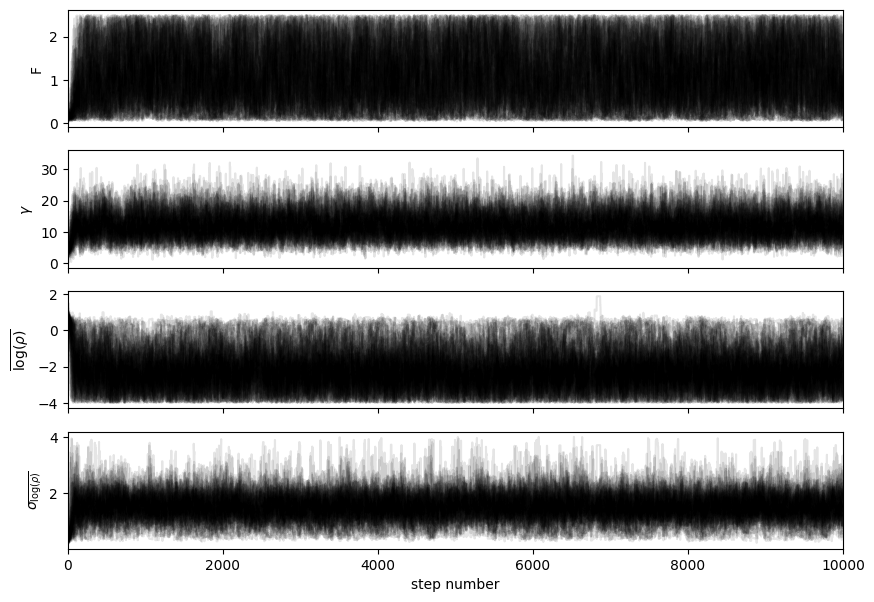

In [19]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["F", r"$\gamma$", r"$\overline{\log(\rho)}$",r"$\sigma_\overline{\log(\rho)}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [20]:
tau = sampler.get_autocorr_time()
print(tau)

[122.02399143  68.73753579 115.6990432   93.01458832]


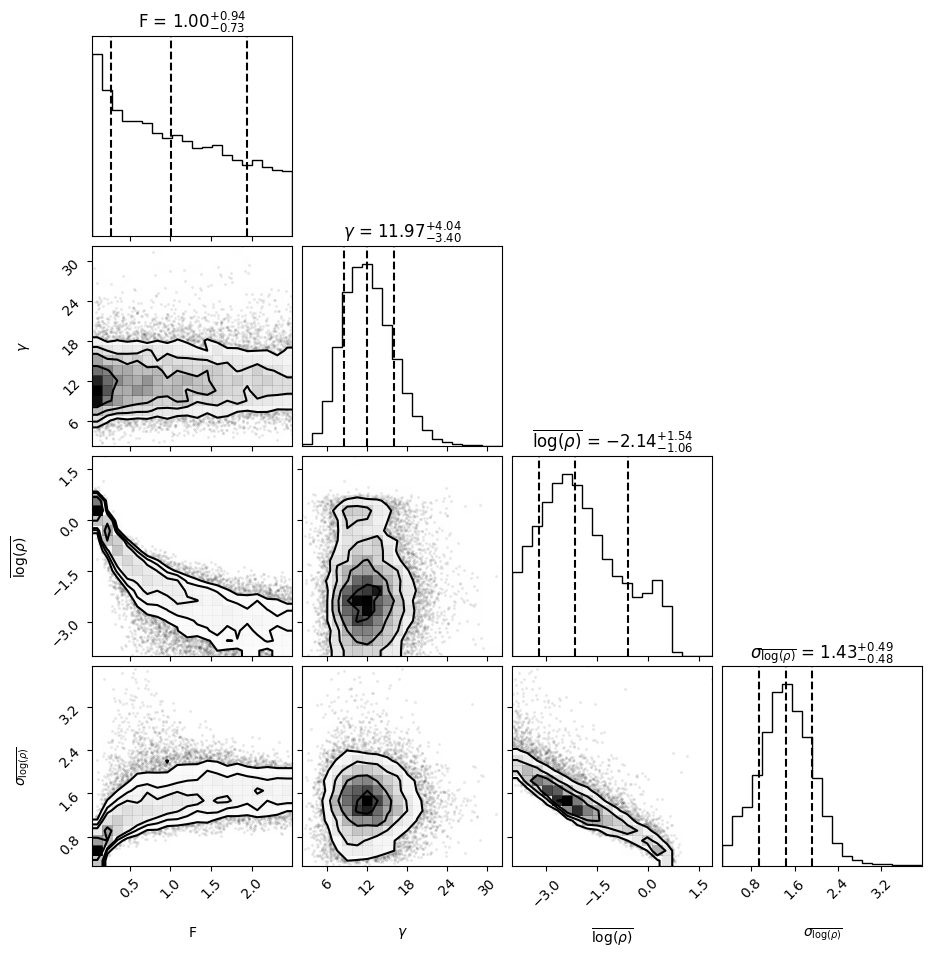

In [21]:
flat_samples = sampler.get_chain(discard=1000, flat=True, thin=40)
fig = corner.corner(flat_samples, labels=labels,quantiles=[0.16,0.5,0.84],show_titles=1)#, truths=[m_true, b_true, np.log(f_true)])
plt.savefig('figs/'+sampStr+ageStr+'Corner'+cornerString+'.pdf',bbox_inches='tight')
np.save('output/flatSamples'+sampStr+ageStr+cornerString+'.npy',flat_samples)

# Prior using Blake et al. 2010
(limit tight companions)

In [22]:
blakeF   =  0.025
blakeFUE =  0.086
blakeFLE = -0.016

def lnLkB(p):
    F, g, mlp, slp = p
    
    R = ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (qqs**g) * np.exp(-1.*((lpps-mlp)**2.)/(2.*slp**2.)) * dqs * dlps
    
    ##### Poisson
    #P = np.sum(np.log((R**dets)*np.exp(-1.*R*sens)))
    #P = np.sum(dets*np.log(R) - (R*sens))

    ##### Binomial
    #lP = np.sum(np.log((R**dets)*(1.-R)**(sens-dets))
    lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))

    #blake info
    smallSep = lpps<0.
    FsmallSep = np.sum(R*smallSep)
    #print(FsmallSep)
    if (FsmallSep>blakeF):
        lBP = -0.5*((blakeF - FsmallSep)/blakeFUE)**2 
    else:
        lBP = -0.5*((blakeF - FsmallSep)/blakeFLE)**2 
    
    return lP +lBP

def lnPB(p):
    prior = lnPrior(p)
    if not np.isfinite(prior):
        return -np.inf
    lk = lnLkB(p)
    if not np.isfinite(lk):
        return -np.inf
    return prior + lk

In [23]:
#p0 = emcee.utils.sample_ball([0.2,1.8,0.85,0.3],[0.05,0.5,0.1,0.04],50)
#nwalkers , ndim = p0.shape

samplerB = emcee.EnsembleSampler(nwalkers,ndim,lnPB)
samplerB.run_mcmc(p0, 10000, progress=True)

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_4038/2549629339.py:16: RuntimeWarning: divide by zero encountered in log
  lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_4038/2549629339.py:16: RuntimeWarning: invalid value encountered in multiply
  lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))
100%|█████████████████████████████████████| 10000/10000 [01:56<00:00, 85.53it/s]


State([[ 1.12178608e-01  5.92894498e+00  4.95217947e-01  5.88098516e-01]
 [ 2.37163879e-01  1.38044735e+01 -7.01563331e-01  1.07749995e+00]
 [ 1.84551658e-01  7.39743918e+00 -4.50865215e-01  1.09551564e+00]
 [ 1.38464022e-01  1.15460092e+01 -3.41394893e-02  9.40987977e-01]
 [ 1.52482769e-01  2.00098651e+01 -1.75057398e-01  7.82203923e-01]
 [ 1.46371413e-01  1.32032225e+01  7.06290420e-02  7.60674650e-01]
 [ 1.97653723e-01  1.17475891e+01 -1.57308495e+00  2.09575229e+00]
 [ 5.00892533e-02  1.94053850e+01  6.22919830e-01  4.36900348e-01]
 [ 1.58657136e-01  8.09142804e+00  2.50667842e-01  7.35871605e-01]
 [ 8.45807606e-02  1.12241748e+01  3.18310274e-01  6.17833298e-01]
 [ 9.11741448e-02  1.88011363e+01  5.35459799e-02  5.03362315e-01]
 [ 2.04840657e-01  7.71196245e+00 -2.37015309e-01  7.19781987e-01]
 [ 6.73001939e-02  1.36059570e+01  3.59609797e-01  4.34396330e-01]
 [ 9.30954267e-02  8.77723786e+00  7.35480176e-02  7.16119075e-01]
 [ 8.80839466e-02  1.04740858e+01  1.16233566e-01  8.063

[56.30741998 50.21111745 56.99973832 57.73421568]


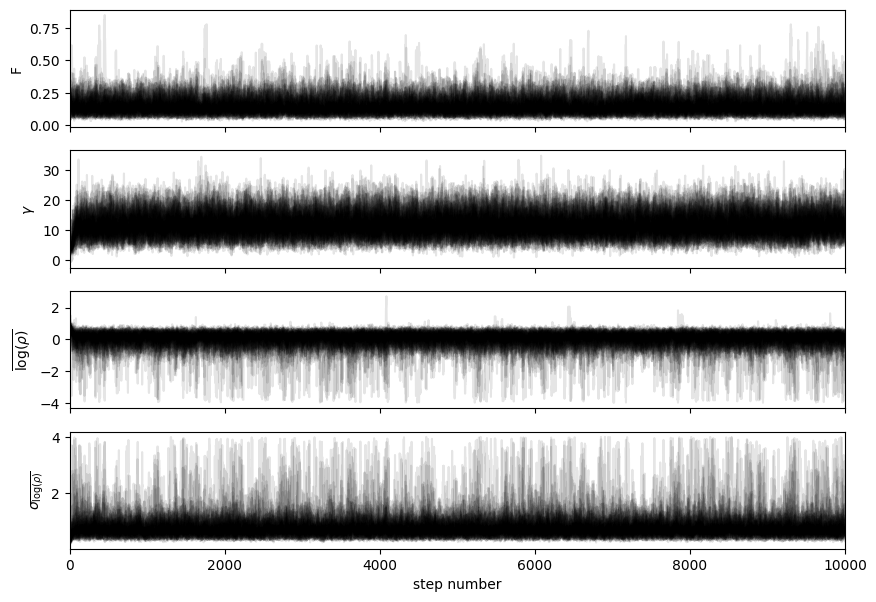

In [24]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = samplerB.get_chain()
labels = ["F", r"$\gamma$", r"$\overline{\log(\rho)}$",r"$\sigma_\overline{\log(\rho)}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

tau = samplerB.get_autocorr_time()
print(tau)

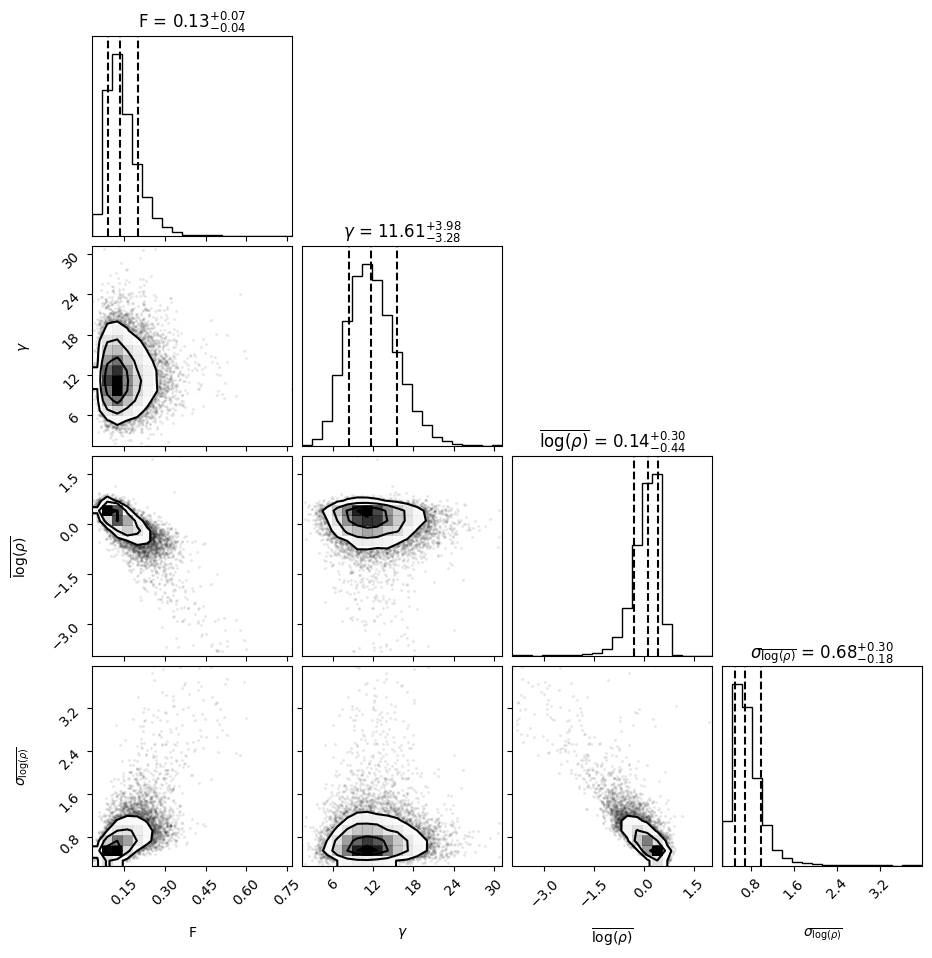

In [25]:
flat_samples = samplerB.get_chain(discard=1000, flat=True, thin=40)
fig = corner.corner(flat_samples, labels=labels,quantiles=[0.16,0.5,0.84],show_titles=1)#, truths=[m_true, b_true, np.log(f_true)])
plt.savefig('figs/'+sampStr+ageStr+'Corner'+cornerString+'Blake.pdf',bbox_inches='tight')
np.save('output/flatSamples'+sampStr+ageStr+cornerString+'Blake.npy',flat_samples)